In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
from scikitplot.metrics import plot_roc_curve

<div class="alert alert-block alert-success">
<p>Read in the data</p>
</div>

In [2]:
rain = pd.read_csv('seattle_rain_train.csv')
print(rain.head())
rain.shape

DATE  PRCP  TMAX  TMIN  RAIN  TMIDR  TRANGE  MONTH  SEASON  \
0  1948-01-30  0.03    47    30     1   38.5      17      1       1   
1  1948-01-31  0.21    35    27     1   31.0       8      1       1   
2  1948-02-01  0.03    39    30     1   34.5       9      2       1   
3  1948-02-02  0.00    43    26     0   34.5      17      2       1   
4  1948-02-03  0.20    38    26     1   32.0      12      2       1   

   TMRW_RAIN  TMRW_PRCP  YEST_RAIN  YEST_PRCP  SUM7_PRCP  SUM14_PRCP  \
0        1.0       0.21        1.0       0.22       0.35        0.56   
1        1.0       0.03        1.0       0.03       0.46        0.77   
2        0.0       0.00        1.0       0.21       0.49        0.80   
3        1.0       0.20        1.0       0.03       0.49        0.80   
4        1.0       0.14        0.0       0.00       0.69        1.00   

   SUM30_PRCP  
0        4.28  
1        4.02  
2        3.46  
3        3.04  
4        2.93  


(18964, 16)

<div class="alert alert-block alert-success">
<p>Choose relevent features (Ignore ID, Date, and TMRW_PRCP)</p>
</div>

In [3]:
target = 'TMRW_RAIN'
features = ['PRCP', 'TMAX', 'TMIN', 'RAIN', 'TMIDR', 'TRANGE', 'MONTH', 'SEASON', 'YEST_RAIN', 'YEST_PRCP', 'SUM7_PRCP', 'SUM14_PRCP', 'SUM30_PRCP']

<div class="alert alert-block alert-success">
<p>Split into train and validation set</p>
</div>

In [4]:
train_data, validation_data = train_test_split(rain, test_size=0.2)

<div class="alert alert-block alert-success">
<p>See what the majority class is and that we can see what we should be more accurate than.</p>
</div>

In [5]:
len(rain[rain['TMRW_RAIN'] == 1]) / len(rain)

0.42491035646488085

<div class="alert alert-block alert-success">
<p>The majority in TMRW_RAIN was 0, appearing 58% of the time. We should be more accurate than that.</p>
</div>

<div class="alert alert-block alert-success">
<h1>Random Forest Classifier</h1>
<p>Starting with Random Forest Classifier. Use GridSearch to find best hyperparameters (takes a bit of time)</p>
</div>

In [6]:
max_depth = [1] + np.arange(5, 16, 5).tolist()
min_samples_leaf = [1] + np.arange(5, 21, 5).tolist()

hyperparameters = {'min_samples_leaf': min_samples_leaf, 'max_depth': max_depth}

search = GridSearchCV(estimator=RandomForestClassifier(), cv=10, return_train_score=True, param_grid=hyperparameters)
search.fit(train_data[features], train_data[target])

print(search.best_params_)

{'max_depth': 10, 'min_samples_leaf': 10}


<div class="alert alert-block alert-success">
<p>Make graphs for accuracy of train and validation data</p>
</div>

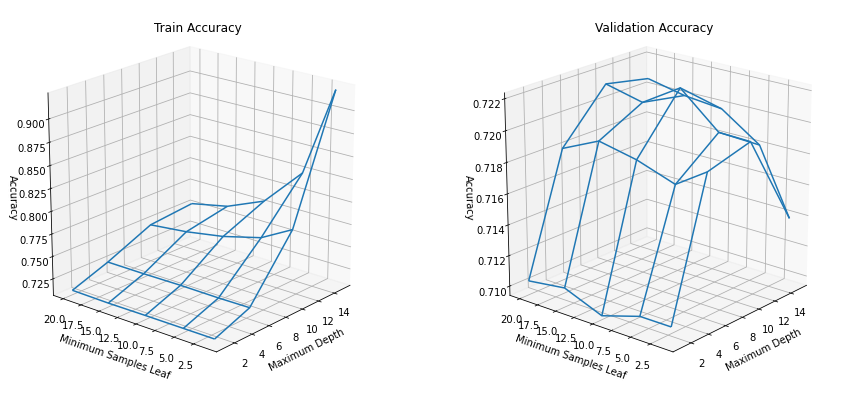

In [7]:
def plot_scores(ax, title, search, hyperparameters, score_key):
    cv_results = search.cv_results_
    scores = cv_results[score_key]
    scores = scores.reshape((len(hyperparameters['max_depth']), len(hyperparameters['min_samples_leaf'])))
    max_depths = cv_results['param_max_depth'].reshape(scores.shape).data.astype(int)
    min_samples_leafs = cv_results['param_min_samples_leaf'].reshape(scores.shape).data.astype(int)
    
    ax.plot_wireframe(max_depths, min_samples_leafs, scores)
    ax.view_init(20, 220)
    ax.set_xlabel('Maximum Depth')
    ax.set_ylabel('Minimum Samples Leaf')
    ax.set_zlabel('Accuracy')
    ax.set_title(title)


fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

plot_scores(ax1, 'Train Accuracy', search, hyperparameters, 'mean_train_score')
plot_scores(ax2, 'Validation Accuracy', search, hyperparameters, 'mean_test_score')

<div class="alert alert-block alert-success">
<p>Get accuracy score</p>
</div>

In [8]:
randomForest = RandomForestClassifier(max_depth=search.best_params_['max_depth'], min_samples_leaf=search.best_params_['min_samples_leaf'])
randomForest.fit(train_data[features], train_data[target])

predictions = randomForest.predict(validation_data[features])
print(accuracy_score(validation_data[target], predictions))

0.7118375955707883


<div class="alert alert-block alert-success">
<p>Get ROC Curve for Random Forest Classifier</p>
</div>

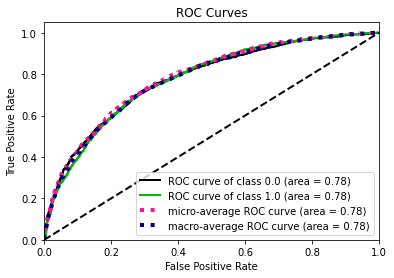

In [9]:
probabilities = randomForest.predict_proba(validation_data[features])
plot_roc_curve(validation_data[target], probabilities)
plt.show()

<div class="alert alert-block alert-success">
<h1>KNearestNeighbor</h1>
</div>

In [10]:
from sklearn.neighbors import KNeighborsClassifier

n_neighbors = np.arange(1, 20)

best_knn = KNeighborsClassifier(n_neighbors=1)
best_error = 0

for n in n_neighbors:
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(train_data[features], train_data[target])

    train_predictions = knn.predict(train_data[features])
    validation_predictions = knn.predict(validation_data[features])

    train_score = accuracy_score(train_data[target], train_predictions)
    validation_score = accuracy_score(validation_data[target], validation_predictions)

    if validation_score > best_error:
        best_error = validation_score
        best_knn = knn

    print("{0} neighbor(s): Training: {1} Validation: {2}".format(n, train_score, validation_score))

1 neighbor(s): Training: 0.9997363390679586 Validation: 0.6158713419456894
2 neighbor(s): Training: 0.7996836068815504 Validation: 0.6303717374110203
3 neighbor(s): Training: 0.7999472678135917 Validation: 0.6380174004745583
4 neighbor(s): Training: 0.7590798233471755 Validation: 0.6482994990772476
5 neighbor(s): Training: 0.7574319425219168 Validation: 0.6580543105721065
6 neighbor(s): Training: 0.742732845560609 Validation: 0.6601634590034273
7 neighbor(s): Training: 0.741414540900402 Validation: 0.6683364091747956
8 neighbor(s): Training: 0.7323182387449739 Validation: 0.669127339836541
9 neighbor(s): Training: 0.7295497989585393 Validation: 0.6712364882678619
10 neighbor(s): Training: 0.7247379869487839 Validation: 0.6717637753756921
11 neighbor(s): Training: 0.72401291938567 Validation: 0.6783548642235697
12 neighbor(s): Training: 0.7201898358710698 Validation: 0.6754547851305036
13 neighbor(s): Training: 0.7176850570166765 Validation: 0.6754547851305036
14 neighbor(s): Training: 

<div class="alert alert-block alert-success">
<p>Not very accurate...</p>
</div>

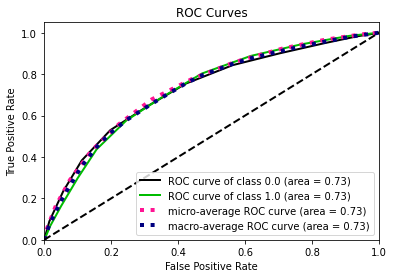

In [11]:
probabilities = best_knn.predict_proba(validation_data[features])

plot_roc_curve(validation_data[target], probabilities)
plt.show()

<div class="alert alert-block alert-success">
<h1>Logistic Regression</h1>
</div>

<div class="alert alert-block alert-success">
<h2>Logistic Regression with L1 Regression</h2>
</div>

In [12]:
hyperparameters = {'penalty': ['l1'], 'C': [1/1, 1/4, 1/10, 1/1e2, 1/1e3, 1/1e5]}

search = GridSearchCV(estimator=LogisticRegression(fit_intercept=False, solver='liblinear'), cv=10, return_train_score=True, param_grid=hyperparameters)
search.fit(train_data[features], train_data[target])

print(search.best_params_)

{'C': 1.0, 'penalty': 'l1'}


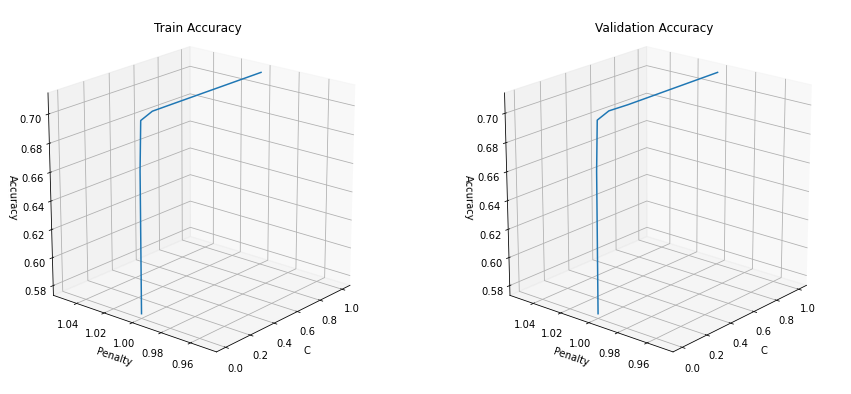

In [13]:
def plot_scores(ax, title, search, hyperparameters, score_key):
    cv_results = search.cv_results_
    scores = cv_results[score_key]
    scores = scores.reshape((len(hyperparameters['C']), len(hyperparameters['penalty'])))
    cs = cv_results['param_C'].reshape(scores.shape).data.astype(float)
    penalties = np.ma.asarray(np.array([1, 1, 1, 1, 1, 1])).reshape(scores.shape).data.astype(int)
    # penalties = cv_results['param_penalty'].reshape(scores.shape).data.astype(int)
    
    ax.plot_wireframe(cs, penalties, scores)
    ax.view_init(20, 220)
    ax.set_xlabel('C')
    ax.set_ylabel('Penalty')
    ax.set_zlabel('Accuracy')
    ax.set_title(title)


fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

plot_scores(ax1, 'Train Accuracy', search, hyperparameters, 'mean_train_score')
plot_scores(ax2, 'Validation Accuracy', search, hyperparameters, 'mean_test_score')

In [14]:
l1_model = LogisticRegression(penalty='l1', C = 1/4, fit_intercept=False, solver='liblinear')
l1_model.fit(train_data[features], train_data[target])

predictions = l1_model.predict(validation_data[features])

weights = l1_model.coef_[0]

for feature, weight in zip(features, weights):
    print("feature: {0}, weight: {1}".format(feature, weight))

accuracy_score(validation_data[target], predictions)

NameError: name 'model' is not defined

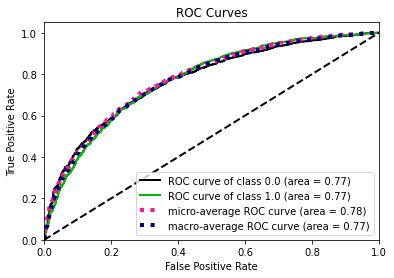

In [15]:
probabilities = l1_model.predict_proba(validation_data[features])
plot_roc_curve(validation_data[target], probabilities)
plt.show()

<div class="alert alert-block alert-success">
<h2>Logistic Regression with L2 Regression</h2>
</div>

In [16]:
hyperparameters = {'penalty': ['l2'], 'C': [1/1, 1/4, 1/10, 1/1e2, 1/1e3, 1/1e5]}

search = GridSearchCV(estimator=LogisticRegression(fit_intercept=False), cv=10, return_train_score=True, param_grid=hyperparameters)
search.fit(train_data[features], train_data[target])

print(search.best_params_)

{'C': 1.0, 'penalty': 'l2'}


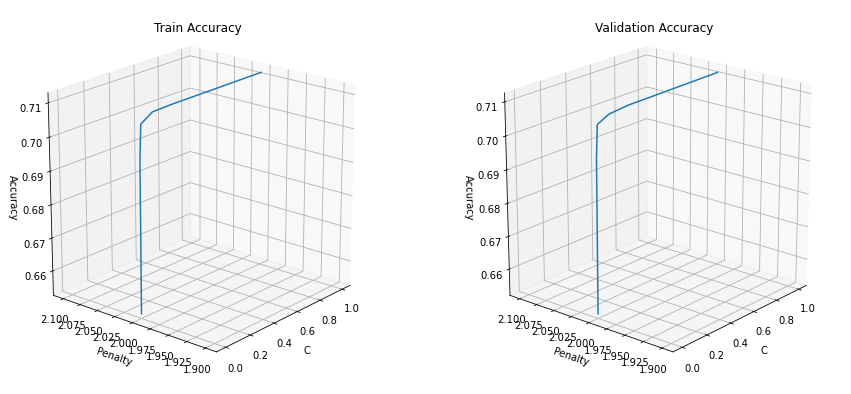

In [17]:
def plot_scores(ax, title, search, hyperparameters, score_key):
    cv_results = search.cv_results_
    scores = cv_results[score_key]
    scores = scores.reshape((len(hyperparameters['C']), len(hyperparameters['penalty'])))
    cs = cv_results['param_C'].reshape(scores.shape).data.astype(float)
    penalties = np.ma.asarray(np.array([2, 2, 2, 2, 2, 2])).reshape(scores.shape).data.astype(int)
    # penalties = cv_results['param_penalty'].reshape(scores.shape).data.astype(int)
    
    ax.plot_wireframe(cs, penalties, scores)
    ax.view_init(20, 220)
    ax.set_xlabel('C')
    ax.set_ylabel('Penalty')
    ax.set_zlabel('Accuracy')
    ax.set_title(title)


fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

plot_scores(ax1, 'Train Accuracy', search, hyperparameters, 'mean_train_score')
plot_scores(ax2, 'Validation Accuracy', search, hyperparameters, 'mean_test_score')

In [18]:
l2_model = LogisticRegression(penalty='l2', C = 1/4, fit_intercept=False)
l2_model.fit(train_data[features], train_data[target])

predictions = l2_model.predict(validation_data[features])

weights = l2_model.coef_[0]

for feature, weight in zip(features, weights):
    print("feature: {0}, weight: {1}".format(feature, weight))

accuracy_score(validation_data[target], predictions)

feature: PRCP, weight: 1.1352383448501686
feature: TMAX, weight: -0.017352005670857682
feature: TMIN, weight: 0.011370474021864016
feature: RAIN, weight: 0.9995626247749562
feature: TMIDR, weight: -0.002990765824511435
feature: TRANGE, weight: -0.028722479692750536
feature: MONTH, weight: 0.034640916712181904
feature: SEASON, weight: -0.13484891641131497
feature: YEST_RAIN, weight: 0.11308315731592807
feature: YEST_PRCP, weight: -0.0009567705212720128
feature: SUM7_PRCP, weight: 0.055926421017793604
feature: SUM14_PRCP, weight: -0.0200603832881623
feature: SUM30_PRCP, weight: 0.08253831778358046


0.7092011600316372

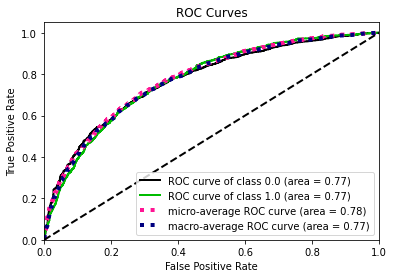

In [19]:
probabilities = l2_model.predict_proba(validation_data[features])
plot_roc_curve(validation_data[target], probabilities)
plt.show()

<div class="alert alert-block alert-success">
<h1>Get Prediction for Test</h1>
</div>

In [20]:
rain_test = pd.read_csv('seattle_rain_test.csv')

predictions = randomForest.predict(rain_test[features])

In [21]:
to_save = rain_test[['Id']].copy()

In [22]:
to_save.loc[:, 'Category'] = predictions

In [23]:
to_save.to_csv('submission.csv', index=False)